In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import json
import seaborn as sns

In [50]:
def normalizar_data(data, formato="%Y-%m-%d"):
    return datetime.fromtimestamp(data).strftime(formato)

In [2]:
arqvs = os.listdir('./outputs')

In [79]:
dicio = {}
moedas = []
for arqv in arqvs:
    moeda = arqv.split('_')[2].split('.')[0]
    with open(f'./outputs/{arqv}') as f:
        data = json.load(f)
    base = data['Data']['Data']
    dates = [item['time'] for item in base]
    hist_fech = [item['close'] for item in base]
    hist_abert = [item['open'] for item in base]
    hist_vol = [item['volumeto'] for item in base]
    dicio[moeda] = {
        'data': dates,
        'hist_fech': hist_fech,
        'hist_abert': hist_abert,
        'hist_vol': hist_vol
    }
    moedas.append(moeda)

In [80]:
dates = [normalizar_data(data) for data in dates]
df_fech = df_abert = df_vol = pd.DataFrame(index=dates)
for moeda in moedas:
    datas = [normalizar_data(d) for d in dicio[moeda]['data']]
    hist_fech = dicio[moeda]['hist_fech']
    df_f = pd.DataFrame(index=datas, data=hist_fech, columns=[moeda])
    df_a = pd.DataFrame(index=datas, data=hist_abert, columns=[moeda])
    df_v = pd.DataFrame(index=datas, data=hist_vol, columns=[moeda])
    df_fech = df_fech.join(df_f)
    df_abert = df_abert.join(df_a)
    df_vol = df_vol.join(df_v)



# VaR

In [154]:
# Create our portfolio of equities
tickers = moedas
 
# Set the investment weights (I arbitrarily picked for example)
weights = np.array(np.full((1,18), 1/18)[0])
 
# Set an initial investment level
initial_investment = 1000

In [173]:
df_fech_pct_change = df_fech[700:].replace(0, np.nan).pct_change()
df_fech_pc_cov = df_fech_pct_change.cov()
# Calculate mean returns for each stock
avg_rets = df_fech_pc_cov.mean()
# Calculate mean returns for portfolio overall, using dot product to 
# normalize individual means against investment weights
 # https://en.wikipedia.org/wiki/Dot_product#:~:targetText=In%20mathematics%2C%20the%20dot%20product,and%20returns%20a%20single%20number.
port_mean = avg_rets.dot(weights)

In [174]:
# Calculate portfolio standard deviation
port_stdev = np.sqrt(weights.T.dot(df_fech_pc_cov).dot(weights))
 
# Calculate mean of investment
mean_investment = (1+port_mean) * initial_investment
             
# Calculate standard deviation of investmnet
stdev_investment = initial_investment * port_stdev

In [175]:
# Select our confidence interval (I'll choose 95% here)
conf_level1 = 0.05

# Using SciPy ppf method to generate values for the
# inverse cumulative distribution function to a normal distribution
# Plugging in the mean, standard deviation of our portfolio
# as calculated above
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
from scipy.stats import norm
cutoff1 = norm.ppf(conf_level1, mean_investment, stdev_investment)

In [176]:
#Finally, we can calculate the VaR at our confidence interval
var_1d1 = initial_investment - cutoff1
var_1d1

89.51795579120108

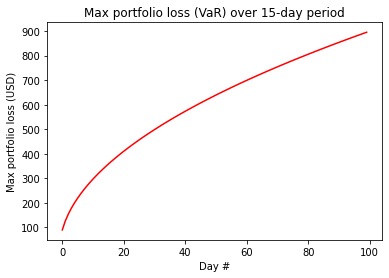

In [177]:
# Calculate n Day VaR
var_array = []
num_days = int(100)
for x in range(1, num_days+1):    
    var_array.append(np.round(var_1d1 * np.sqrt(x),2))

# Build plot
plt.xlabel("Day #")
plt.ylabel("Max portfolio loss (USD)")
plt.title("Max portfolio loss (VaR) over 15-day period")
plt.plot(var_array, "r")

In [ ]:
for m in moedas:
    plt.hist(df_fech_pct_change[m], bins=20)
    plt.xlim(-1, 1)
    plt.title(f'Histograma de {m}')
    plt.text(0.15, 0.9, f'Média: {df_fech_pct_change[m].mean().round(3)}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.show()

# Retorno esperado

In [204]:
# Select our confidence interval (I'll choose 95% here)
conf_level1 = 0.95

# Using SciPy ppf method to generate values for the
# inverse cumulative distribution function to a normal distribution
# Plugging in the mean, standard deviation of our portfolio
# as calculated above
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
from scipy.stats import norm
cutoff_re_1 = norm.ppf(conf_level1, mean_investment, stdev_investment)

In [209]:
re_1d1 = cutoff_re_1 - initial_investment
re_1d1

95.86945060815879

# Otimizar relação Risco - Retorno

In [211]:
rrr = np.round(re_1d1 / var_1d1,2)
rrr

1.07

# Corr Heatmap

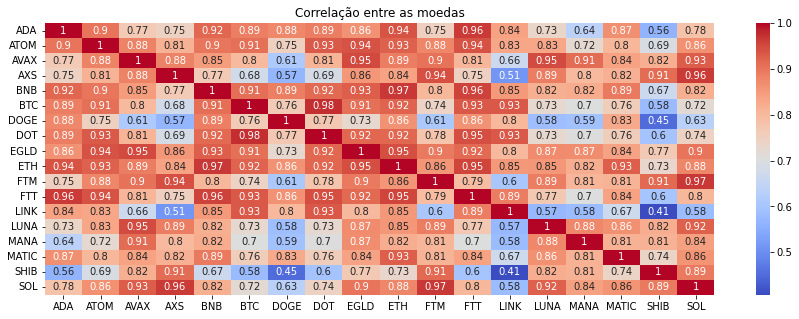

In [66]:
plt.figure(figsize=(15, 5))
heatmap = sns.heatmap(df_fech.corr(), annot=True, cmap='coolwarm')
plt.title('Correlação entre as moedas')
plt.show()

# Gráficos históricos

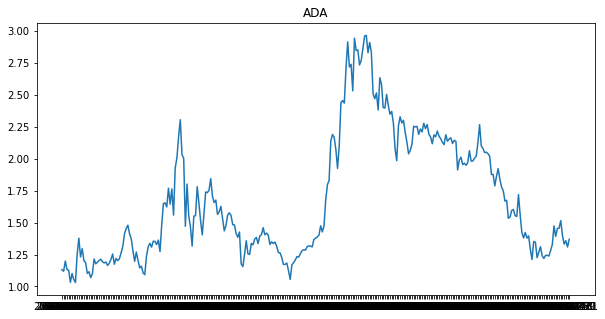

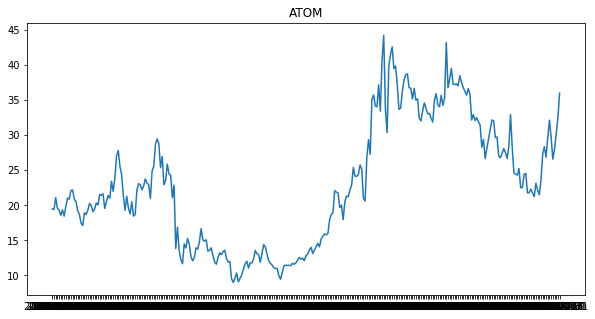

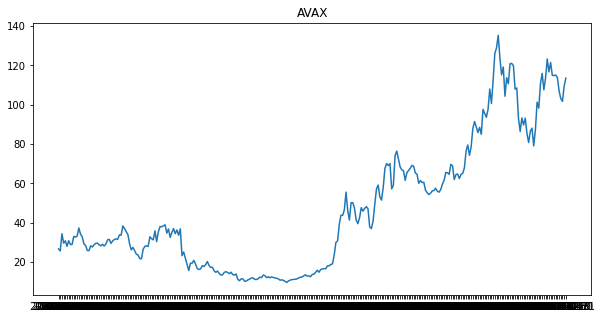

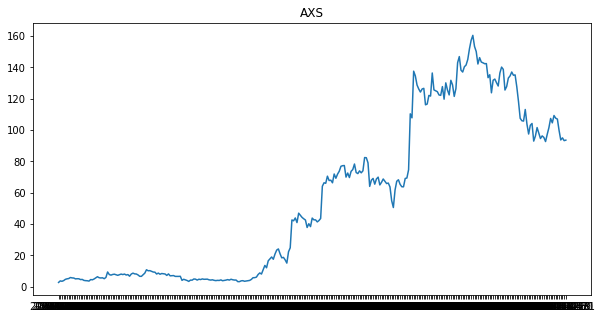

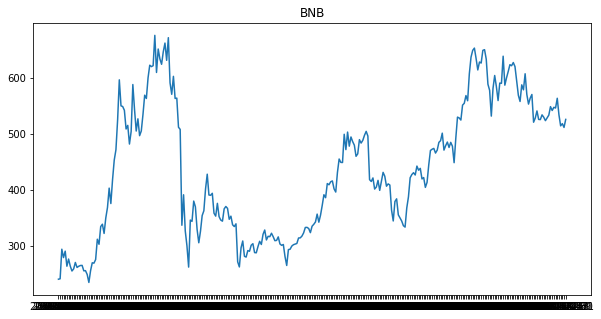

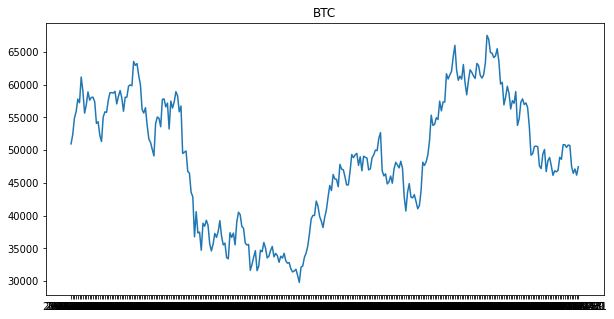

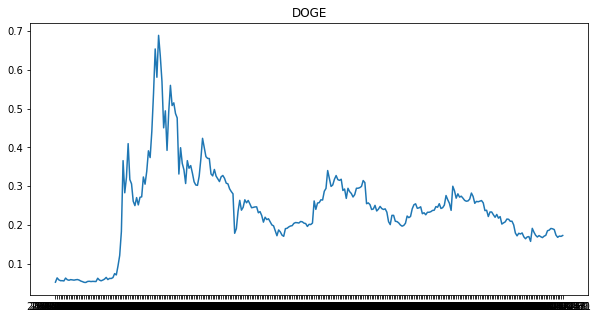

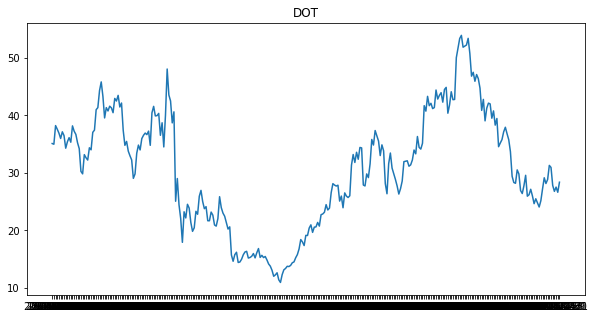

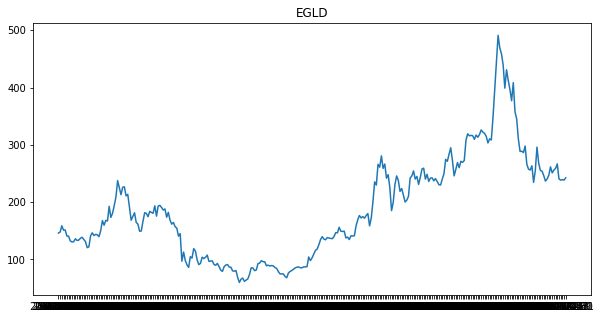

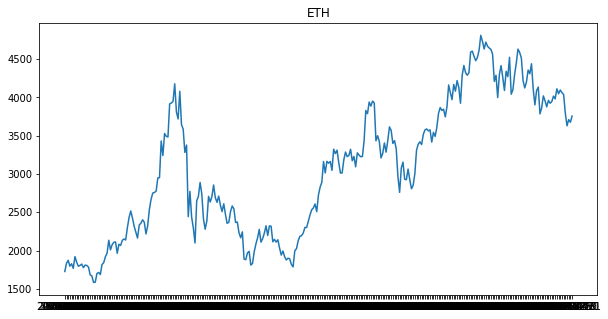

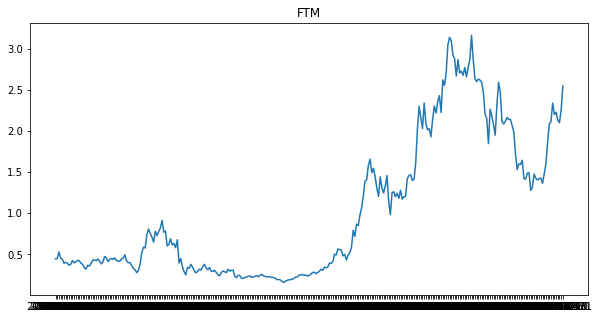

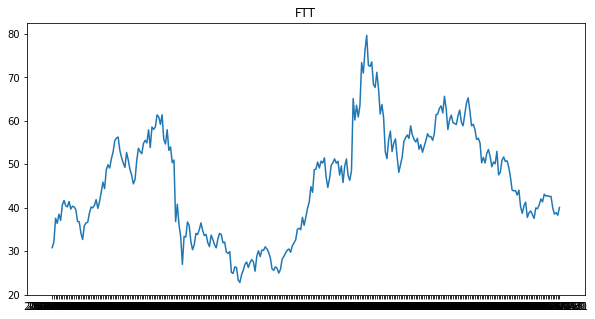

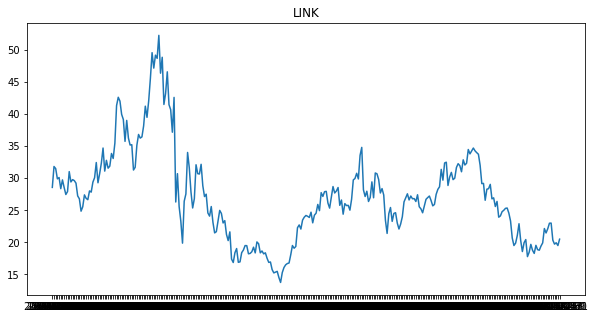

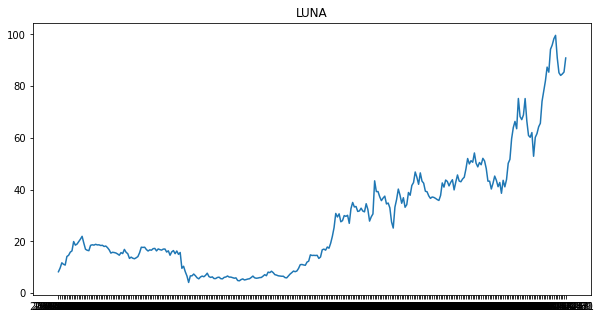

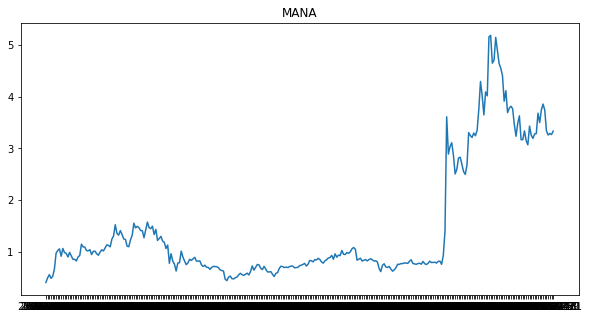

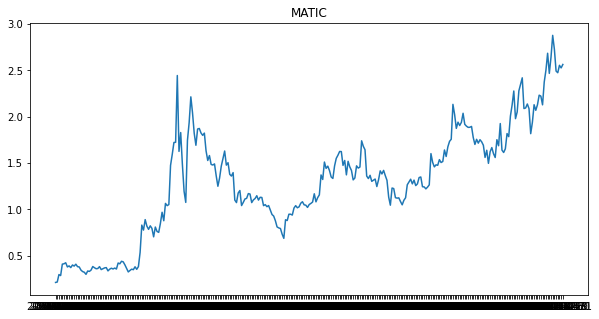

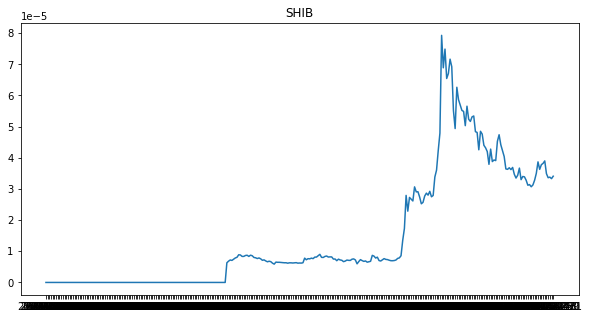

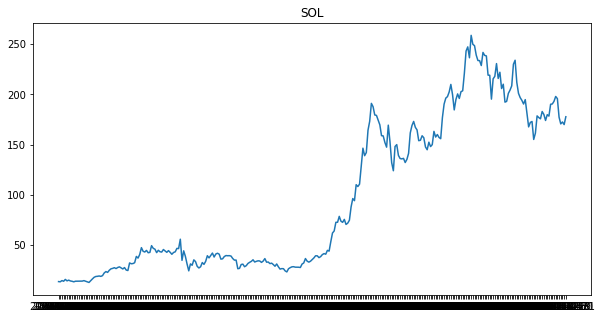

In [58]:
corte = 700
for moeda in dicio.keys():
    plt.figure(figsize=(10, 5))
    plt.plot(df_fech[moeda][corte:])
    plt.title(label=moeda)
    plt.show()
    